# Pion GNN Combined
In this notebook, we take a dataset that contains 3 image channels: 9x9 barrel ECAL, 3x4 barrel HCAL and 3x3 outer HCAL.  We use Google DeepMind's 'Graph Net' data structure to train a tensorflow neural network to apply corrections to the beam distribution.  The data is represented in nodes (the pixels) and edges (the pixel proximity) and we preprocess the data by determining the centroid of each image channel and cropping the image about the centroid in a user-defined range.  After cropping the images, we then connect the nodes according to a nearest neighbor metric, and then we connect only the barrel ECAL and barrel HCAL channels. 
<br> The notebook is organized into the sections: <br>
> **1. Setting up the notebook to run with GPUs and installing libraries** <br>
> **2. Reading in the data** <br>
> **3. Preprocessing the data (cropping and validation splitting)** <br>
> **4. Building the graph network** <br>
> **5. Training the graph net** <br>
> **6. Computing sample statistics to compare the corrected and raw distributions**<br>

Note that the notebook _'GNN Optimization Training'_ should be run before setting the graph net parameters here, otherwise the training may not be optimized for best results.  The _'GNN Optimization Training'_ notebook will output a `.txt` file containing the optimized hyper parameters to be used for training.

## Set-up the Notebook

In [0]:
#@title Initialize the Python Notebook
import sys, ipywidgets as widgets
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title ### Install external libraries
#@markdown <br> 1. Graph Nets (DeepMind)
#@markdown <br> 2. Tensorflow (GPU)
#@markdown <br> 3. Tensorflow Probability
#@markdown <br> 4. Scikit Optimize
%%capture
EXTERNAL_LIBRARIES = "True" #@param ["True","False"]
if EXTERNAL_LIBRARIES.lower() == "true":
  !pip install tensorflow-gpu
  !pip install graph_nets
  !pip install scikit-optimize
  !pip install -U dm-sonnet==1.23
  !pip install tensorflow-probability

## Import Libraries

In [0]:
#@title General Purpose Libraries

import numpy as np
import time, datetime
import re, collections, itertools
import matplotlib.pyplot as plt
import pandas as pd
import random, math
import os, sys
from os import listdir
from os.path import isfile, join
from array import array

In [0]:
#@title Machine Learning Libraries

from graph_nets import blocks, utils_tf, utils_np, modules, graphs
from graph_nets.demos import models
import sonnet as snt
import tensorflow as tf
import keras
from keras.models import Sequential, clone_model, Model
from keras.optimizers import Adam
from keras.layers import InputLayer, Dense, Dropout, Flatten
from keras import regularizers, optimizers, backend
from keras.callbacks import EarlyStopping, ModelCheckpoint

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Using TensorFlow backend.


In [0]:
#@title Data Manipulation and Analysis Libraries

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm, linregress
from scipy import stats
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
import networkx as nx

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Set Program to Run with GPUs

In [0]:
#@title ### Set to run with GPUs { vertical-output: true }

DEVICE_NAME = tf.test.gpu_device_name()
if DEVICE_NAME != '/device:GPU:0':
  raise SystemError('GPU device not found')

# Choose memory allocation option
MEMORY_ALLOCATION = "Dynamic" #@param ["Dynamic","Fixed"]
#@markdown **Dynamic allocation** increases memory based on need as the program runs
#@markdown <br> **Fixed allocation** maintains the same GPU usage throughout the program 

config = tf.ConfigProto(log_device_placement = True)
if MEMORY_ALLOCATION.lower() == "fixed":
  GPU_FRAC = widgets.FloatSlider(min=0, max=1.0,
                 step=0.05, value=0.5,
                 description="GPU Frac",
                 continuous_update=True)
  display(GPU_FRAC)
else:
  config.gpu_options.allow_growth = True
  print("Using dynamic memory growth on {}".format(DEVICE_NAME))

Using dynamic memory growth on /device:GPU:0


In [0]:
#@title Under the hood settings to start the tensorflow session.

if MEMORY_ALLOCATION.lower() == 'fixed':
  config.gpu_options.per_process_gpu_memory_fraction = GPU_FRAC.value
  print("Using {}% of {}".format(GPU_FRAC.value*100,
                                DEVICE_NAME))
  
SESSION = tf.Session(config=config)

## Bookkeeping

In [0]:
#@title Create a folder to hold the results from this run and indicate where test dataset is contained.

GOOGLE_DRIVE = './drive/My Drive/Colab Notebooks/'

MODEL_DIR = GOOGLE_DRIVE + "GNN model/" + str(datetime.date.today()) + "/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

TAG_NUM = str(datetime.datetime.now().hour)
TAG = datetime.datetime.today().strftime('%m-%d') + ' (' + TAG_NUM +')'

print('Folder name containing the data:')
#FOLDER = input()
FOLDER = 'Pion Test Beam'
DATA_DIR = GOOGLE_DRIVE + "/" + FOLDER

RUNTIME = time.time() # track the total runtime
print(TAG)

Folder name containing the data:


## 1. Data Import

In [0]:
#@title Determine the file names within the specified dataset folder

FILES = [f for f in listdir(DATA_DIR) if isfile(join(DATA_DIR, f))] # reads in file names

# Declare the file data dicts
files99 = {} # Barrel ECAL
files33 = {} # Outer HCAL
files34 = {} # Barrel HCAL

print("Using files:")
for FILE in FILES:
  print(FILE)

Using files:
pi-200GeV.txt
pi-300GeV.txt
pi-100GeV.txt
pi-150GeV.txt
pi-9GeV.txt
pi-50GeV.txt
pi-30GeV.txt
pi-20GeV.txt
pi-8GeV.txt
pi-7GeV.txt
pi-6GeV.txt
pi-5GeV.txt
pi-4GeV.txt
pi-3GeV.txt
pi-2GeV.txt


Iterate through the different energy labels to populate the file data dicts

In [0]:
#@title Populate dict

for ENERGY in FILES:
    buffer99 = []
    buffer34 = []
    buffer33 = []
    FILE = open(DATA_DIR + '/' + ENERGY) 
    DATA = FILE.readlines() # data is a list containing j lines
    for VALUE in DATA:
        # fromstring turns a sentence (l.strip) into a 1D array
        LINE = np.fromstring(VALUE.strip(),sep = " ") # 1D array
        if len(LINE) == 9:
            buffer99.append(LINE)
        if len(LINE) == 4:
            buffer34.append(LINE)
        if len(LINE) == 3:
            buffer33.append(LINE)
    files99[ENERGY] = buffer99
    files34[ENERGY] = buffer34
    files33[ENERGY] = buffer33

Define some functions for shaping the $9\times9$ and $3\times4$ data into image arrays.

In [0]:
#@title Image Helper Functions

def shapeimages9x9(lines):
    img9x9 = {}
    # keys identifies the dataset 'labels' from 'lines' (i.e. pi-9GeV)
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            # extend adds 'line' to the list 'img'
            img.extend(line)
            if counter%9 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img9x9[key] = imgs
    return img9x9

def shapeimages3x4(lines):
    img3x4 = {}
    for key in lines.keys():
        counter = 1
        imgs = []
        img = []
        for line in lines[key]:
            img.extend(line)
            if counter%3 == 0:
                imgs.append(img)
                img = []
            counter += 1
        img3x4[key] = imgs
    return img3x4

In [0]:
#@markdown Apply the helper functions to the 9x9 and 3x4 data.

img9x9 = shapeimages9x9(files99)
img3x4 = shapeimages3x4(files34)

### Visualize the Shaped Images

In [0]:
#@title Sample selection for viewing

# Choosing the sample to view
KEY_NUM = np.random.randint(0, len(files99.keys()))

# key num = 'pi-8GeV.txt' # can fix the data file viewed
KEY = list(files99.keys())[KEY_NUM] # randomly selects an energy label to view
SMP_NUM = np.random.randint(0, np.shape(img9x9[KEY])[0]-1) # randomly selects an image sample to view
# smp_num = 0 # can fix the sample number viewed

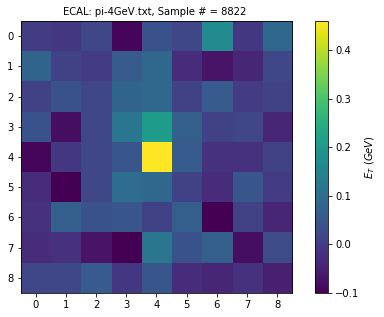

In [0]:
#@title 9x9 Barrel ECAL Sample Image
plt.figure(figsize=(8,5))
plt.imshow(np.array(img9x9[KEY][SMP_NUM]).reshape((9,9)))
cbar = plt.colorbar()
cbar.set_label(r'$E_T\ (GeV)$')
plt.title('ECAL: {}, Sample # = {} '.format(KEY, SMP_NUM),
         fontsize=10)
plt.xticks(np.arange(0,9,1))
plt.show()

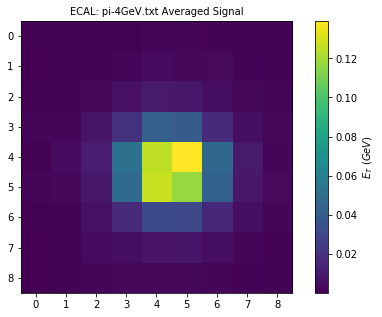

In [0]:
#@title 9x9 Barrel ECAL Averaged Image
plt.figure(figsize=(8,5))
plt.imshow(np.mean(img9x9[KEY],axis=0).reshape((9,9)))
cbar = plt.colorbar()
cbar.set_label(r'$E_{T}\ (GeV)$')
plt.title('ECAL: {} Averaged Signal'.format(KEY),
         fontsize=10)
plt.xticks(np.arange(0,9,1))
plt.show()

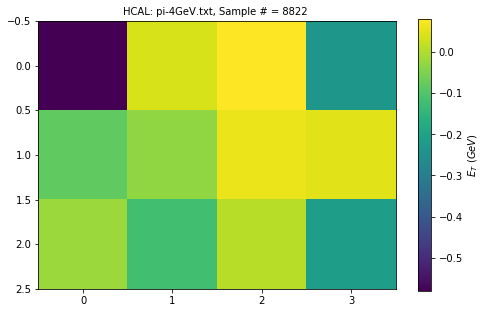

In [0]:
#@title 3x4 Barrel HCAL Sample Image
plt.figure(figsize=(8,5))
plt.imshow(np.array(img3x4[KEY][SMP_NUM]).reshape((3,4)))
cbar = plt.colorbar()
cbar.set_label(r'$E_T\ (GeV)$')
plt.title('HCAL: {}, Sample # = {} '.format(KEY, SMP_NUM),
         fontsize=10)
plt.xticks(np.arange(0,4,1))
plt.show()

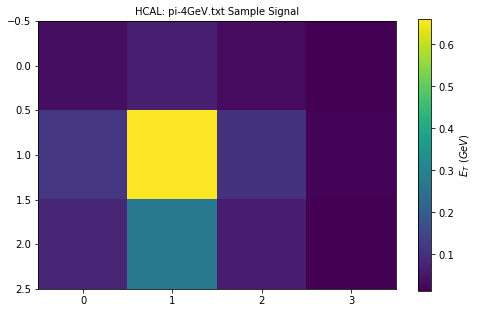

In [0]:
#@title 3x4 Barrel HCAL Average Image
plt.figure(figsize=(8,5))
plt.imshow(np.mean(img3x4[KEY],axis=0).reshape((3,4)))
cbar = plt.colorbar()
cbar.set_label(r'$E_{T}\ (GeV)$')
plt.title('HCAL: {} Sample Signal'.format(KEY),
         fontsize=10)
plt.xticks(np.arange(0,4,1))
plt.show()

## 2. Preprocessing
> 1. Only take samples from each dataset based on the smallest number of samples out of all the datasets
> 2. Splitting the dataset into training, validation and test sets

### Set the values of variables used in preprocessing

In [0]:
#@title Define values used during preprocessing

RATIO = 0.1 # fraction of sample that will be validation data
RNG_SPLIT = np.random.randint(0,100) # choose the seed for deciding how to split the training and validation data
# RNG_SPLIT = 0 # set this for same split

In [0]:
#@title Declare some containers for the data

x_EB = [] # contains EB data for both training and validation
x_HB = [] # contains HB data for both training and validation
y = [] # contains truth values for training

ENERGY_LIST = []

In [0]:
#@title Determine the minimal number of samples in the energy datasets
samples = [] # array to hold MIN_SAMPLES candidates
for i in img9x9:
    samples.append(np.shape(img9x9[i])[0])
    
MIN_SAMPLES = min(samples)
#MIN_SAMPLES = 1000 # set this

In [0]:
#@title Sample evenly across all energy datasets to build the train/test set
start_time = time.time()

for i in img9x9:
  num_energy = np.shape(img9x9[i])[0] # entries for a given energy
  perc_smp = np.around((float(MIN_SAMPLES) / num_energy),3)
  print('{}: {} % images used'.format(i, perc_smp*100))
  img_EB = np.array(img9x9[i])
  img_HB = np.array(img3x4[i])
  
  x_EB.extend(img_EB[0:MIN_SAMPLES,:])
  x_HB.extend(img_HB[0:MIN_SAMPLES,:])  

  # associate truth value array with the training and testing sets
  energy = np.int(re.findall(r'\d+',i)[0]) # extracts energy value
  y.extend(np.full(MIN_SAMPLES,energy)) # populates the truth dataset
  
  ENERGY_LIST.append(energy)
    
elapsed_time = time.time() - start_time
print('Elapsed time: {} seconds'.format(elapsed_time))
a = np.shape(x_EB)[0]
b = MIN_SAMPLES * np.size(FILES)
print('x_EB and x_HB have {} images; expected {} images.'.format(a,b))

pi-200GeV.txt: 81.8 % images used
pi-300GeV.txt: 26.200000000000003 % images used
pi-100GeV.txt: 50.7 % images used
pi-150GeV.txt: 69.1 % images used
pi-9GeV.txt: 25.6 % images used
pi-50GeV.txt: 58.5 % images used
pi-30GeV.txt: 100.0 % images used
pi-20GeV.txt: 49.4 % images used
pi-8GeV.txt: 37.7 % images used
pi-7GeV.txt: 20.4 % images used
pi-6GeV.txt: 18.5 % images used
pi-5GeV.txt: 18.4 % images used
pi-4GeV.txt: 25.2 % images used
pi-3GeV.txt: 30.599999999999998 % images used
pi-2GeV.txt: 70.89999999999999 % images used
Elapsed time: 5.105523109436035 seconds
x_EB and x_HB have 110610 images; expected 110610 images.


In [0]:
#@title Split into Training and Validation sets
#@markdown No test set will be used since comparison to Abdullin et. al.
#@markdown requires using the full dataset (unevenly sampled across energies)


x_train_EB, x_val_EB, x_train_HB, x_val_HB, y_train, y_val = train_test_split(
  x_EB, x_HB, y,
  test_size = RATIO, random_state = RNG_SPLIT)

# reshape the datasets
x_train_EB = np.reshape(x_train_EB,((-1,9,9)))
x_val_EB = np.reshape(x_val_EB,((-1,9,9)))
x_train_HB = np.reshape(x_train_HB,((-1,3,4)))
x_val_HB = np.reshape(x_val_HB,((-1,3,4)))
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

## 3. Build the Graph Neural Network

In [0]:
#@title Define variables to be used for building the Graph Neural Network (Edit Me)
#@markdown >BATCH_SIZE<br> NUM_LAYERS<br> LATENT_SIZE

# GNN parameters
BATCH_SIZE = 50
NUM_LAYERS = 1 # hard-coded number of layers
LATENT_SIZE = 50 # hard-coded number of latent layers

# Higher Level Variables
TRAIN_SIZE = len(y_train) - len(y_train) % BATCH_SIZE
VAL_SIZE = len(y_val) - len(y_val) % BATCH_SIZE

In [0]:
#@title Instantiate some containers

# Dicts
input_feed_train = {}
input_feed_valid = {}

input_graphs_dict = []

In [0]:
#@title Define helper functions for building graph network
#@markdown 1. __findCentroidNeighbors__(cal_image,
#@markdown y_range, x_range, img_id)<br>
#@markdown 2. __createInputFeed__(itr, batch_size,
#@markdown EB_X, HB_X, Y, is_train) <br>
#@markdown 3. __lossOps__(output_list, y)
#@markdown 4. __makeMLPModel()__


# selects (y_range, x_range) pixels around the centroid
def findCentroidNeighbors(cal_image, y_range, x_range, img_id):
  y_length = cal_image.shape[0]
  x_length = cal_image.shape[1]
  
  assert(y_range <= y_length)
  assert(x_range <= x_length)
  
  cul_x = 0.0
  cul_y = 0.0
  energy_total = 0.0 # holds the sum of the nearest neighbor energy
  for node_y in range(y_length - 1):
    for node_x in range(x_length - 1):
      pixel = cal_image[node_x, node_y]
      cul_x += (node_x)*pixel
      cul_y += (node_y)*pixel
      energy_total += pixel
      
  if(energy_total > 1e-10):
    (centroid_y, centroid_x) = (cul_y / energy_total, cul_x / energy_total)
  else:
    (centroid_y, centroid_x) = ((y_length - 1)/2.0, (x_length - 1)/2.0)
    
  (centroid_y, centroid_x) = round(centroid_y, 14), round(centroid_x, 14)
  
  (y_begin, y_end) = (int(math.ceil(centroid_y - y_range / 2.0)),
                      int(math.ceil(centroid_y + y_range / 2.0)))
  (x_begin, x_end) = (int(math.ceil(centroid_x - x_range / 2.0)),
                      int(math.ceil(centroid_x + x_range / 2.0)))
  
  if y_begin < 0:
    (y_begin, y_end) = (0, y_range)
  if y_end > y_length:
    (y_begin, y_end) = (y_length - y_range, y_length)
  if x_begin < 0:
    (x_begin, x_end) = (0, x_range)
  if x_end > x_length:
    (x_begin, x_end) = (x_length - x_range, x_length)
  assert(y_end - y_begin == y_range)
  assert(x_end - x_begin == x_range)
  
  return ((y_begin, y_end), 
          (x_begin, x_end),
          (centroid_y, centroid_x))
  
def createInputFeed(itr, batch_size, EB_X, HB_X, Y, is_train):
  # total number of itr = training size / batch size
  start_idx = itr * batch_size
  end_idx = start_idx + batch_size
  
  img_dict = []
  for image_idx in range(start_idx, end_idx):
    
    (y_begin, y_end), (x_begin, x_end), (_, _) = findCentroidNeighbors(
      EB_X[image_idx], Y_RANGE_EB, X_RANGE_EB, image_idx)
    pixels_ecal = np.array(EB_X[image_idx, y_begin: y_end, x_begin: x_end])
    (y_begin, y_end), (x_begin, x_end), (_, _) = findCentroidNeighbors(
      HB_X[image_idx], Y_RANGE_HB, X_RANGE_HB, image_idx)
    pixels_hcal = np.array(HB_X[image_idx, y_begin: y_end, x_begin: x_end])
    
    nodes, edges, receivers, senders = [], [], [], []
    global_features = [0.0]
    
    nodes_selected_ecal = pixels_ecal > ZERO_SUP_THRESHOLD_EB
    nodes_selected_hcal = pixels_hcal > ZERO_SUP_THRESHOLD_HB
    assert((np.count_nonzero(nodes_selected_ecal) > 0) or 
          (np.count_nonzero(nodes_selected_hcal) > 0))
    
    # EB Nodes
    coord_to_node_id_ecal = {}
    for node_y in range(Y_RANGE_EB):
      for node_x in range(X_RANGE_EB):
        if nodes_selected_ecal[node_y, node_x] == True:
          node_id = len(nodes)
          coord_to_node_id_ecal[(node_y, node_x)] = node_id
          nodes.append([pixels_ecal[node_y, node_x], node_y, node_x, +1])
    # Connect immediate neighbors in EB Nodes
    for (node_y, node_x), this_node_id in coord_to_node_id_ecal.items():
      neighbors_to_check = [(node_y - 1, node_x), (node_y + 1, node_x),
                            (node_y, node_x - 1), (node_y, node_x + 1),
                            (node_y, node_x)]
      for (neighbor_y, neighbor_x) in neighbors_to_check:
        if (neighbor_y, neighbor_x) in coord_to_node_id_ecal:
          edges.append([1.0])
          senders.append(this_node_id)
          receivers.append(coord_to_node_id_ecal[(neighbor_y, neighbor_x)])
          
          
    # HB Nodes
    coord_to_node_id_hcal = {}
    for node_y in range(Y_RANGE_HB):
      for node_x in range(X_RANGE_HB):
        if nodes_selected_hcal[node_y, node_x] == True:
          node_id = len(nodes)
          coord_to_node_id_hcal[(node_y, node_x)] = node_id
          nodes.append([pixels_hcal[node_y, node_x], node_y, node_x, -1])
    
    # Connect immediate neighbors in HB nodes
    for (node_y, node_x), this_node_id in coord_to_node_id_hcal.items():
      neighbors_to_check = [(node_y - 1, node_x), (node_y + 1, node_x),
                            (node_y, node_x - 1), (node_y, node_x + 1),
                            (node_y, node_x)]
      for (neighbor_y, neighbor_x) in neighbors_to_check:
        if (neighbor_y, neighbor_x) in coord_to_node_id_hcal:
          edges.append([1.0])
          senders.append(this_node_id)
          receivers.append(coord_to_node_id_hcal[(neighbor_y, neighbor_x)])
          
          
    # Connect all EB nodes with HB nodes
    ecal_hcal_connections = itertools.product(coord_to_node_id_ecal.values(),
                                             coord_to_node_id_hcal.values())
    for (ecal_node_id, hcal_node_id) in ecal_hcal_connections:
      edges.append([1.0])
      senders.append(ecal_node_id)
      receivers.append(hcal_node_id)
      edges.append([1.0])
      senders.append(hcal_node_id)
      receivers.append(ecal_node_id)
      
    img_dict.append({
        "nodes": nodes,
        "edges": edges,
        "receivers": receivers,
        "senders": senders,
        "globals": global_features
    })
  # data_dicts_to_graphs_tuple produces an instance of graphs.GraphsTuple
  input_graphs = utils_np.data_dicts_to_graphs_tuple(img_dict)
  feed_dict = {input_graph_placeholders: input_graphs,
               label_placeholders: Y[start_idx:end_idx, np.newaxis]}
  
  return feed_dict
      
def lossOps(output_list, y):
  if not isinstance(output_list, collections.Sequence):
    output_list = [output_list]
  loss = tf.reduce_mean( tf.square( (y - output_list[-1].globals) / y ) )
  return loss
  
def makeMLPModel():
  return snt.Sequential([
      snt.nets.MLP([LATENT_SIZE] * NUM_LAYERS,
      activate_final = False,
      activation = tf.nn.softplus,
      use_bias = False),
      snt.LayerNorm()
  ])

In [0]:
#@title Instantiate the graph network components
#@markdown 1. __Nodes__: physics objects <br>
#@markdown 2. __Edges__: object relations <br>
#@markdown 3. __Receivers__: instances of relation's first object <br>
#@markdown 4. __Senders__: instances of relation's second object <br>
#@markdown 5. __Globals__: characteristics of the graph network

tf.reset_default_graph()

for _ in range(BATCH_SIZE):
  nodes = [[0.0, 0.0, 0.0, 0]]
  edges = [[0.0]]
  receivers = [0]
  senders = [0]
  globals = [0.0]
  input_graphs_dict.append({
      "nodes":nodes,\
      "edges":edges,\
      "receivers":receivers,\
      "senders":senders,\
      "globals":globals
  })
  
input_graph_placeholders = utils_tf.placeholders_from_data_dicts(
  input_graphs_dict, force_dynamic_num_graphs = False)

label_placeholders = tf.compat.v1.placeholder(tf.float32, shape=(BATCH_SIZE, 1))

In [0]:
#@title Define classes for the graph network
#@markdown 1. __MLPGraphIndependent()__
#@markdown 2. __MLPGraphNetwork()__
#@markdown 3. __EncodeProccessDecode()__

class MLPGraphIndependent(snt.AbstractModule):
  
  def __init__(self, name = "MLPGraphIndependent"):
    super(MLPGraphIndependent, self).__init__(name = name)
    with self._enter_variable_scope():
      self._network = modules.GraphIndependent(
        edge_model_fn = makeMLPModel,
        node_model_fn = makeMLPModel,
        global_model_fn = makeMLPModel)
      
  def _build(self, inputs):
    return self._network(inputs)
  
class MLPGraphNetwork(snt.AbstractModule):
  def __init__(self, name = "MLPGraphNetwork"):
    super(MLPGraphNetwork, self).__init__(name = name)
    with self._enter_variable_scope():
      self._network = modules.GraphNetwork(
          makeMLPModel, makeMLPModel, makeMLPModel,\
          edge_block_opt = {"use_globals": False},\
          node_block_opt = {"use_globals": False, "use_sent_edges": False},\
          global_block_opt = {"use_globals": False}
          )
  def _build(self, inputs):
    return self._network(inputs)
  
class EncodeProcessDecode(snt.AbstractModule):
  def __init__(
      self,
      edge_output_size = None,
      node_output_size = None,
      global_output_size = None,
      name = 'EncodeProcessDecode'):
    super(EncodeProcessDecode, self).__init__(name = name)
    self._encoder = MLPGraphIndependent()
    self._core = MLPGraphNetwork()
    self._decoder = MLPGraphIndependent()
  
    if edge_output_size is None:
      edge_fn = None
    else:
      edge_fn = lambda: snt.Linear(edge_output_size, name = 'edge_output')
    if node_output_size is None:
      node_fn = None
    else:
      node_fn = lambda: snt.Linear(node_output_size, name = 'node_output')
    if global_output_size is None:
      global_fn = None
    else:
      global_fn = lambda: snt.Linear(global_output_size, name= "global_output")
    with self._enter_variable_scope():
      self._output_transform = modules.GraphIndependent(edge_fn, node_fn,
                                                     global_fn)

  def _build(self, input_op, num_processing_steps):
    latent = self._encoder(input_op)
    latent0 = latent
    output_ops = []
    for _ in range(num_processing_steps):
      core_input = utils_tf.concat([latent0, latent], axis = 1)
      latent = self._core(core_input)
    
      decoded_op = self._decoder(latent)
      output_ops.append(self._output_transform(decoded_op))
    return output_ops
  

## 5. Train the Graph Network

In [0]:
#@title Define parameters for running the training (Edit Me)

LR_BOUNDS = [5, 10] # [x,y] corresponds to x epochs for one LR value
LR_VALUES = [4e-3, 2e-3, 1e-3]
ZERO_SUP_THRESHOLD_EB = -10.0
ZERO_SUP_THRESHOLD_HB = -10.0
SAVE_PERIODIC = False
EPOCH_PERIOD = 1 
LOG_PERIOD = 0 # seconds
EPOCHS_FROM_MIN = 0
NUM_EPOCHS = 100
PROCESS_STEPS = 5
PATIENCE = 10
DELTA = 1e-7
N_BEST = 1 # number of models to have saved

# Dataset parameters
Y_RANGE_EB, X_RANGE_EB = 7, 7
Y_RANGE_HB, X_RANGE_HB = 3, 3

# Higher level parameters
NUM_TRAIN_ITR = TRAIN_SIZE // BATCH_SIZE
NUM_VAL_ITR = VAL_SIZE // BATCH_SIZE

In [0]:
#@title Declare some lists

# Lists
train_loss_list = []
train_epoch_count = []
valid_loss_list = []
valid_epoch_count = []

In [0]:
#@title Helper functions for running training and validation

def runTraining():
  train_loss = []
  num_batch_trained = 0
  for itr in range(NUM_TRAIN_ITR):
    input_feed = createInputFeed(
      itr, BATCH_SIZE, x_train_EB, x_train_HB, y_train, is_train = True)
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op
    }, feed_dict = input_feed)
    train_loss.append(train_values["loss"])
    num_batch_trained += 1
  train_loss_avg = sum(train_loss) / num_batch_trained
  return train_loss_avg

def runValidation():
  valid_loss = []
  num_batch_eval = 0
  for itr_valid in range(NUM_VAL_ITR):
    input_feed = createInputFeed(
      itr_valid, BATCH_SIZE, x_val_EB, x_val_HB, y_val, is_train = False)
    valid_values = sess.run({
      "loss": loss_op
      }, feed_dict = input_feed)
    valid_loss.append(valid_values["loss"])
    num_batch_eval += 1
  valid_loss_avg = sum(valid_loss) / num_batch_eval
  return valid_loss_avg

In [0]:
#@title Instantiate the neural network components

%%capture

model = EncodeProcessDecode(global_output_size = 1)
output_list = model(input_graph_placeholders, PROCESS_STEPS)

loss_op = lossOps(output_list, label_placeholders)

LR_EPOCH_NUM = tf.Variable(0, trainable = False, dtype = tf.int32)
learning_rate = tf.train.piecewise_constant(
    LR_EPOCH_NUM, LR_BOUNDS, LR_VALUES
)
increment_lr_epoch_num_op = tf.assign(LR_EPOCH_NUM, LR_EPOCH_NUM + 1)
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op)

saver = tf.compat.v1.train.Saver(max_to_keep = N_BEST)
saver_periodic = tf.compat.v1.train.Saver(max_to_keep = 10000)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#@title Run Training

sess = tf.compat.v1.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()
last_log_time = start_time

# buffer
valid_loss_avg = 0

print("# (epoch), T (elapsed), Loss train, Loss valid")

for epoch in range(NUM_EPOCHS):
  
  train_loss_avg = runTraining()
  if epoch == 0: valid_loss_min = train_loss_avg
  train_loss_list.append(train_loss_avg)
  train_epoch_count.append(epoch + 1)
  sess.run(increment_lr_epoch_num_op)
  
  if SAVE_PERIODIC and (epoch + 1) % EPOCH_PERIOD == 0:
    saver_periodic.save(sess, "./model-%s-Periodic" % (start_time),
                       global_step = epoch + 1)
    
  elapsed_since_last_log = time.time() - last_log_time
  if elapsed_since_last_log > LOG_PERIOD:
    valid_loss_avg = runValidation()
    elapsed = ( time.time() - start_time ) / 60.0
    last_log_time = time.time()
    print("# {:05d},   {:.1f} min,     {:.5f},   {:.5f}".format(
      epoch+1, elapsed, train_loss_avg, valid_loss_avg))
    valid_loss_list.append(valid_loss_avg)
    valid_epoch_count.append(epoch + 1)
    EPOCHS_FROM_MIN += 1
  if (valid_loss_avg < valid_loss_min) and\
     (valid_loss_min - valid_loss_avg) > DELTA :
    valid_loss_min = valid_loss_avg
    EPOCHS_FROM_MIN = 0
    saver.save(sess,
              MODEL_DIR + "GNN Model " + TAG
              )
  if EPOCHS_FROM_MIN > PATIENCE: break # early stopping

print("Training completed in {:.1f} min, best validation loss = {:.3f}".format(
      (time.time() - start_time) / 60.0, valid_loss_min))

# (epoch), T (elapsed), Loss train, Loss valid
# 00001,   13.2 min,     0.25578,   0.11898
# 00002,   26.3 min,     0.12143,   0.09800
# 00003,   39.3 min,     0.10412,   0.08980
# 00004,   52.3 min,     0.09501,   0.08482
# 00005,   65.3 min,     0.09120,   0.08303
# 00006,   78.2 min,     0.08882,   0.07893
# 00007,   91.2 min,     0.07999,   0.07976
# 00008,   104.2 min,     0.07946,   0.07904
# 00009,   117.2 min,     0.07880,   0.07783
# 00010,   130.2 min,     0.07814,   0.07701
# 00011,   143.2 min,     0.07749,   0.07660
# 00012,   156.2 min,     0.07408,   0.07188
# 00013,   169.1 min,     0.07359,   0.07157
# 00014,   182.1 min,     0.07317,   0.07115
# 00015,   195.1 min,     0.07282,   0.07067
# 00016,   208.1 min,     0.07253,   0.07031
# 00017,   221.0 min,     0.07228,   0.07001
# 00018,   234.0 min,     0.07206,   0.06978
# 00019,   247.0 min,     0.07186,   0.06959
# 00020,   260.0 min,     0.07167,   0.06945
# 00021,   272.9 min,     0.07150,   0.06934
# 00022,   285.

In [0]:
#@title Visualize training history
plt.close()

plt.plot(train_epoch_count, train_loss_list, 'b-')
plt.plot(valid_epoch_count, valid_loss_list, 'r-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')

plt.grid(b = True, which = 'major')
plt.grid(b = True, which = 'minor', linestyle = ':')

plt.show()

In [0]:
#@title Save a .csv of the optimized hyper parameters
param_file = open(MODEL_DIR + "GNN Log File " + TAG + ".txt", "w")
param_file.write("GNN Parameters \n")
param_file.write("\n---------------------------------")
param_file.write("\nOptimized Parameters:")
param_file.write("\n Batch Size: {}".format(BATCH_SIZE))
param_file.write("\n Hidden Layers: {}".format(NUM_LAYERS))
param_file.write("\n Latent Size: {}".format(LATENT_SIZE))
param_file.write("\n Process Steps: {}".format(PROCESS_STEPS))
param_file.write("\n Learning Rates: {}".format(LR_VALUES))
param_file.write("\n Learning Rate Bounds: {}".format(LR_BOUNDS))
param_file.close()

print('Running training with hyper parameters: \
\n Batch Size = {} \
\n Hidden Layers = {} \
\n Latent Size = {} \
\n Process Steps = {} \
\n Learning Rate = {} \
\n Learning Rate Bounds = {}'.format(BATCH_SIZE, NUM_LAYERS, LATENT_SIZE,
                                    PROCESS_STEPS, LR_VALUES, LR_BOUNDS))

In [0]:
#@title Load the model
%%capture

#SESSION_PATH = MODEL_DIR
SESSION_PATH = GOOGLE_DRIVE + "GNN model/2019-09-10/"
#FILE_NAME = "GNN Model " + TAG
FILE_NAME = "GNN Model 09-10 (13)"

sess = tf.compat.v1.Session()

saver = tf.train.import_meta_graph(SESSION_PATH + FILE_NAME + ".meta")
saver.restore(sess, tf.train.latest_checkpoint(SESSION_PATH))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./drive/My Drive/Colab Notebooks/GNN model/2019-09-10/GNN Model 09-10 (13)


In [0]:
#@title Apply the model to the full dataset and compute statistics

x_pred_e = {}
diff_e = {}
predictions = {}
differences = {}
nom_eng_dict = {}

pred_mu = {}
pred_sigma = {}
pred_res = {}
pred_det = {}

pred_res_list = []
pred_eng_list = []
pred_sigma_list = []
nom_eng_list = []

START_TIME = time.time()
for energy in img9x9: # iterates through each of the beam energies
    x_EB_eng = []
    x_HB_eng = []
    y_eng = []
    
    x_pred_e[energy] = []
    diff_e[energy] = []
    
    x_EB_eng.extend(np.array(img9x9[energy]))
    x_HB_eng.extend(np.array(img3x4[energy]))

    eng = np.int(re.findall(r'\d+', energy)[0])
    
    y_eng.extend(np.full(len(x_EB_eng), eng))
    
    ENG_DATA_SIZE = len(x_EB_eng) - len(x_EB_eng) % BATCH_SIZE
    NUM_ITR = ENG_DATA_SIZE // BATCH_SIZE
    
    x_EB_eng = np.asarray(x_EB_eng).reshape((-1,9,9))
    x_HB_eng = np.asarray(x_HB_eng).reshape((-1,3,4))
    y_eng = np.asarray(y_eng)
    
    for itr_test in range(NUM_ITR):
      input_feed = createInputFeed(itr_test, BATCH_SIZE,
                                  x_EB_eng,
                                  x_HB_eng,
                                  y_eng, 
                                  False)
      test_values = sess.run({  "predicted_energy": output_list[-1].globals
                             }, feed_dict = input_feed)
      batch_energy = np.concatenate(test_values["predicted_energy"]).ravel()
      batch_diff = y_eng[itr_test*BATCH_SIZE: (itr_test+1)*BATCH_SIZE] - batch_energy

      x_pred_e[energy].append(batch_energy)
      diff_e[energy].append(batch_diff)
  
    
    x_pred_e[energy] = np.asarray(x_pred_e[energy]).ravel()
    
    filter_quartile_pred = np.percentile(x_pred_e[energy], (0.5, 99.5))
    
    pred_data = []
    # filters predicted data according to set percentiles
    for p in x_pred_e[energy]:
        if p >= filter_quartile_pred[0] and p <= filter_quartile_pred[1]:
            pred_data.append(p)
            
    mu_fit = np.mean(pred_data)
    sigma_fit = np.std(pred_data)
    
    pred_mu[energy] = mu_fit
    pred_sigma[energy] = sigma_fit
    pred_res[energy] = sigma_fit / mu_fit
    pred_det[energy] = x_pred_e[energy]
    
    pred_res_list.append( sigma_fit / mu_fit )
    pred_eng_list.append( mu_fit )
    pred_sigma_list.append( sigma_fit )
    
    nom_eng_list.append( eng )
    nom_eng_dict[eng] = energy
    
    predictions[energy] = (x_pred_e[energy])
    differences[energy] = (diff_e[energy])
    print('Analysis of {} GeV completed at {} seconds'.format(eng,
                                        np.around(time.time() - START_TIME),3))

Analysis of 200 GeV completed at 48.0 seconds
Analysis of 300 GeV completed at 195.0 seconds
Analysis of 100 GeV completed at 271.0 seconds
Analysis of 150 GeV completed at 326.0 seconds
Analysis of 9 GeV completed at 477.0 seconds
Analysis of 50 GeV completed at 542.0 seconds
Analysis of 30 GeV completed at 581.0 seconds
Analysis of 20 GeV completed at 660.0 seconds
Analysis of 8 GeV completed at 762.0 seconds
Analysis of 7 GeV completed at 951.0 seconds
Analysis of 6 GeV completed at 1160.0 seconds
Analysis of 5 GeV completed at 1370.0 seconds
Analysis of 4 GeV completed at 1523.0 seconds
Analysis of 3 GeV completed at 1649.0 seconds
Analysis of 2 GeV completed at 1704.0 seconds


In [0]:
#@title Compute raw energy values

x = []

for i in img9x9:
  img_EB = np.array(img9x9[i])
  img_HB = np.array(img3x4[i])
  img_comb_arr = []
  for j in range(np.shape(img9x9[i])[0]):
    img_comb_buffer = np.concatenate((img_EB[j], img_HB[j]))
    img_comb_arr.append(img_comb_buffer)
    
  img_comb = np.array(img_comb_arr)
  
  x.extend(img_comb)

In [0]:
#@title Fit the raw data

x_o = {}
raw_filter = {}
raw_mu = {}
raw_sigma = {}
raw_res = {}
raw_det = {}

raw_res_list = []
raw_eng_list = []
raw_sigma_list = []

for energy in set(y):
    x_o[energy] = []  
for i in range(len(y)):
    x_o[y[i]].append(x[i])

for energy in img9x9:
    eng = np.int(re.findall(r'\d+', energy)[0])
    print('Fitting {} (GeV) data'.format(eng))
    raw_buffer = [i.sum() for i in x_o[eng]]
        
    filter_quartile_raw = np.percentile(raw_buffer, (0.01, 0.99))
        
    raw_filter[energy] = []

    for t in raw_buffer:
        if t >= filter_quartile_raw[0] and t <= filter_quartile_raw[1]:
            raw_filter[energy].append(t)
    
    mu_fit, sigma_fit = np.mean(raw_filter[energy]), np.std(raw_filter[energy])

    raw_mu[energy] = mu_fit
    raw_sigma[energy] = sigma_fit
    raw_res[energy] = sigma_fit / mu_fit
    raw_det[energy] = (raw_buffer) 
        
    raw_res_list.append( sigma_fit / mu_fit )
    raw_eng_list.append( mu_fit )
    raw_sigma_list.append( sigma_fit )

Fitting 200 (GeV) data
Fitting 300 (GeV) data
Fitting 100 (GeV) data
Fitting 150 (GeV) data
Fitting 9 (GeV) data
Fitting 50 (GeV) data
Fitting 30 (GeV) data
Fitting 20 (GeV) data
Fitting 8 (GeV) data
Fitting 7 (GeV) data
Fitting 6 (GeV) data
Fitting 5 (GeV) data
Fitting 4 (GeV) data
Fitting 3 (GeV) data
Fitting 2 (GeV) data


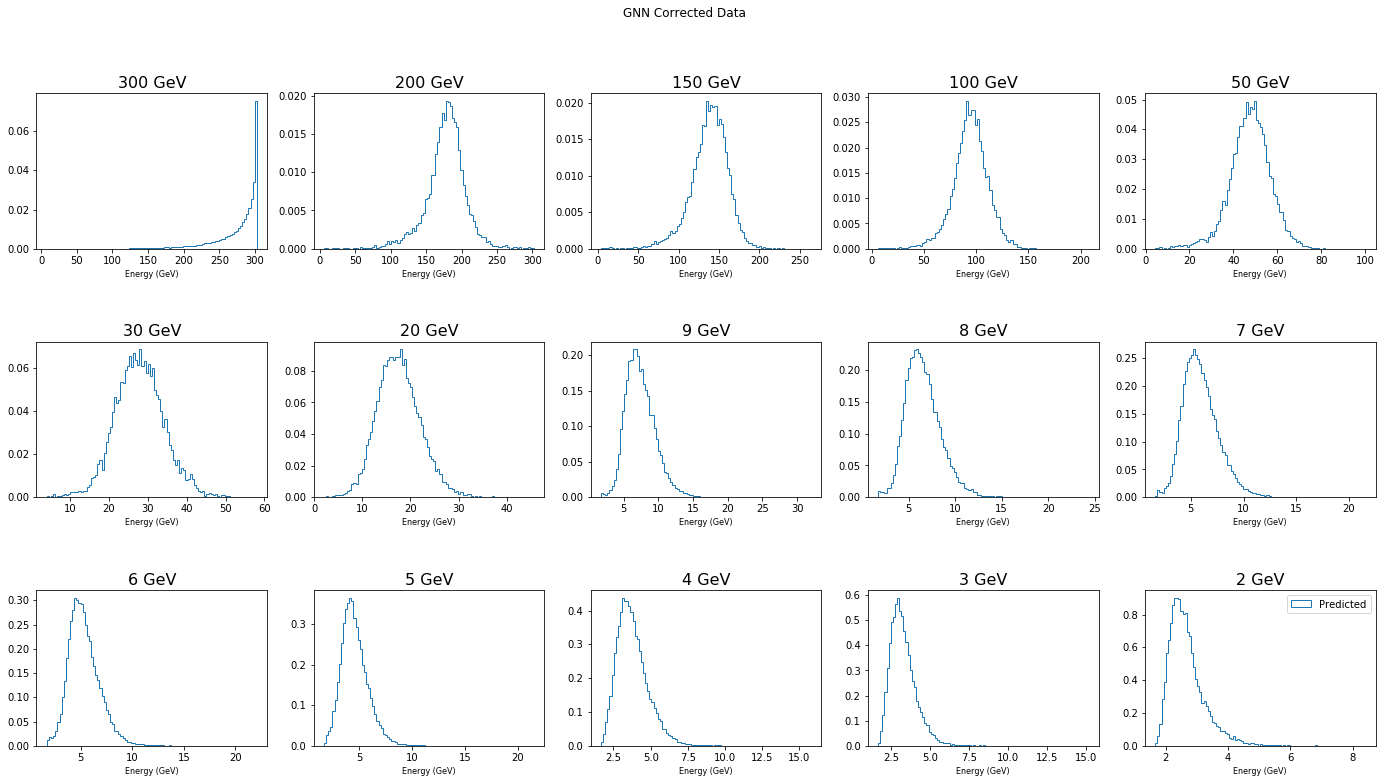

In [0]:
#@title Plot the predicted data

keys = sorted(list(nom_eng_dict.keys()))
keys.sort()
keys.reverse()

plt.close()
plt.figure(figsize=(24,12))

plt.suptitle('GNN Corrected Data')

fig_num = 1 # this will iterate up to populate the subplots

NBIN = 100

for i in keys:
    plt.subplot(3, 5, fig_num)
    fig_num += 1
    
    # plotting the fit for the corrected data
    plt.hist(predictions[nom_eng_dict[i]], NBIN,
                    histtype = 'step', density = 'True',
                    label = 'Predicted')
    #plt.hist(raw_det[nom_eng_dict[i]], NBIN,
    #        histtype = 'step', density = 'True',
    #        label = 'Raw')
    
    plt.title('{} GeV'.format(i), fontsize = 16)
    plt.xlabel('Energy (GeV)', fontsize = 8)
    plt.subplots_adjust(hspace = 0.6)

plt.legend(loc = 'best')

plt.savefig(MODEL_DIR + 'GNN Predicted Distribution '+ TAG + '.png')

plt.show()

In [0]:
#@title Display the sample statistics for the predicted distributions

df = pd.DataFrame({'Pred Mean' : [pred_mu[i] for i in pred_mu],
                   'Pred Sigma' : [pred_sigma[i] for i in pred_sigma],
                   'Pred Resolution' : [pred_res[i] for i in pred_res],
                   'Raw Mean' : [raw_mu[i] for i in raw_mu],
                   'Raw Sigma' : [raw_sigma[i] for i in raw_sigma],
                   'Raw Resolution' : [raw_res[i] for i in raw_res]},
                         pred_mu).sort_values(by = ['Pred Mean'])
df.to_csv(MODEL_DIR + 'GNN Sample Mean and RMS ' + TAG + '.txt',
         sep = ' ', float_format = '%.5f', index = True, header = True)
df

,Pred Mean,Pred Sigma,Pred Resolution,Raw Mean,Raw Sigma,Raw Resolution
pi-2GeV.txt,2.661133,0.542559,0.203883,11.373889,2.079578,0.182838
pi-3GeV.txt,3.232867,0.779246,0.241039,18.776806,3.909601,0.208214
pi-4GeV.txt,3.755159,0.992364,0.264267,1.887083,0.711902,0.377250
pi-5GeV.txt,4.525514,1.210770,0.267543,1.185000,0.737249,0.622151
pi-6GeV.txt,5.287057,1.427211,0.269944,1.328356,0.563949,0.424546
pi-7GeV.txt,5.920679,1.618423,0.273351,1.130000,0.734083,0.649631
pi-8GeV.txt,6.535887,1.807194,0.276503,1.634583,0.666256,0.407600
pi-9GeV.txt,7.384058,2.028871,0.274764,130.007500,30.004558,0.230791
pi-20GeV.txt,17.505148,4.323781,0.247001,46.089583,16.842715,0.365434
pi-30GeV.txt,27.790001,6.029986,0.216984,39.489583,9.924411,0.251317
